In [27]:
"""
Sources:
https://towardsdatascience.com/logistic-regression-a-simplified-approach-using-python-c4bc81a87c31
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
"""


# Import libraries
import numpy as np
import pandas as pd

In [28]:
# Import packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
# Import Titanic dataset
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
# Find samples with empty (null) feature points
train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

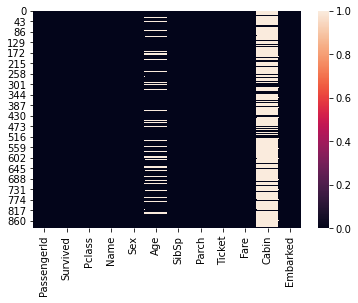

In [31]:
# Visualize empty data points
sns.heatmap(train.isnull())
# We can see here that there are many null points in the Cabin and Age features

<AxesSubplot:xlabel='Survived', ylabel='count'>

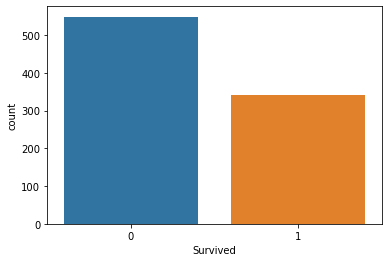

In [32]:
# Have fun with data; mess around with it
sns.countplot(x="Survived", data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

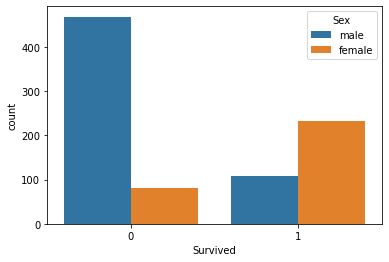

In [33]:
# Do more with data (Added hue aspect)
sns.countplot(x='Survived', hue='Sex', data=train)

# We can see that more females survived than males

<AxesSubplot:xlabel='Survived', ylabel='count'>

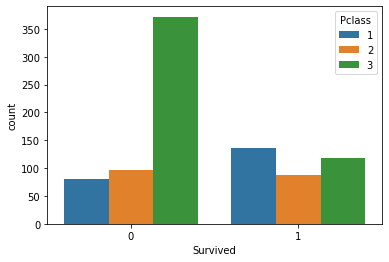

In [34]:
# Do more with data (Change hue to passenger class)
sns.countplot(x='Survived', hue='Pclass', data=train)

# Many more in 3rd class died 

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

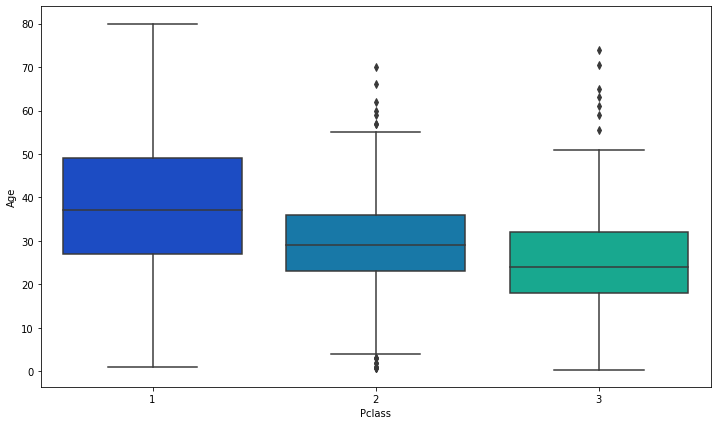

In [35]:
# Graph the ages of passengers to better predict mean ages
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass', y='Age', data=train, palette='winter')

# We see that those in first class tend to be older

In [36]:
# Create function to return ages appropriate for each class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24
    else:
        return Age

In [37]:
# Apply function to data
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis = 1)

<AxesSubplot:>

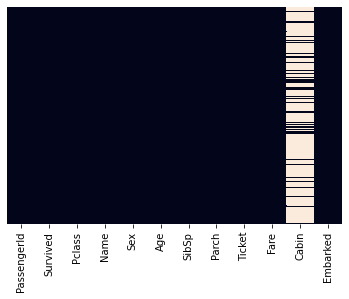

In [38]:
# Check heatmap again to see if the data has been filled out
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)


In [39]:
# Drop cabin column
train.drop('Cabin', axis=1, inplace=True)


In [40]:
# We must now convert categorical features into values that the algorithm can understand
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [41]:
# Convert features into dummy characters
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [42]:
# Now that we converted the features we needed, we can drop the old ones with some that we do not need
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

In [43]:
# Concatenate the converted features back
train = pd.concat([train,sex,embark], axis=1)

In [44]:
# Look at how the dataset looks now
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [45]:
# Test train split (splits our training data into a train set and a test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),
                                                    train['Survived'], test_size=0.30,
                                                    random_state=101)


In [46]:
# Import Random Forest algorithm and train it
from sklearn.ensemble import RandomForestClassifier
randFstModel = RandomForestClassifier()
randFstModel.fit(X_train, y_train)
predictions = randFstModel.predict (X_test)

In [47]:
# Evaluate the model
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
print(classification_report(y_test,predictions, target_names=["Died", "Survived"]))


              precision    recall  f1-score   support

        Died       0.80      0.94      0.86       154
    Survived       0.89      0.69      0.78       114

    accuracy                           0.83       268
   macro avg       0.85      0.81      0.82       268
weighted avg       0.84      0.83      0.83       268



In [48]:
# Different metrics other than Precision, Recall, and F1

# Get probabilities for log loss and ROC Curve
rf_probs = randFstModel.predict_proba(X_test)
print("Log Loss:", log_loss(y_test, rf_probs))


Log Loss: 0.48106428954849234


No Skill: ROC AUC=0.500
RF: ROC AUC=0.850


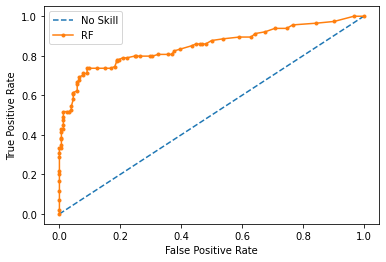

In [50]:
# Manual creation of ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

# Define variables for probabilities
ns_probs = [0 for _ in range(len(y_test))]
# Random Forest probabilities are calculated above
rf_probs = rf_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RF')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


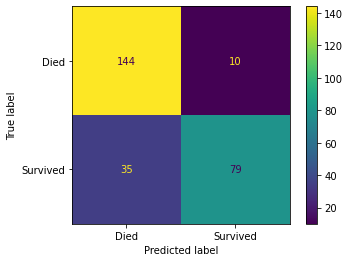

In [51]:
# Create and Display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)

confMatDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
confMatDisplay.plot()